<a href="https://colab.research.google.com/github/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Opt_Attack_for_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [ ]:
!git clone https://github.com/ndb796/attackbox

Cloning into 'attackbox'...
remote: Enumerating objects: 594, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 594 (delta 7), reused 14 (delta 6), pack-reused 575
Receiving objects: 100% (594/594), 74.55 MiB | 29.25 MiB/s, done.
Resolving deltas: 100% (298/298), done.
Checking out files: 100% (191/191), done.


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

import os
import time
import shutil

#### <b>Load Dataset</b>

In [ ]:
def load_model(model, filename):
    """ Load the training model """
    model.load_state_dict(torch.load(filename))


def load_mnist_data(batch_size=1):
    """ Load MNIST data from torchvision.datasets 
        input: None
        output: minibatches of train and test sets 
    """
    # MNIST Dataset
    train_dataset = torchvision.datasets.MNIST(root='./data/mnist', train=True, transform=torchvision.transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(root='./data/mnist', train=False, transform=torchvision.transforms.ToTensor())

    # Data Loader (Input Pipeline)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset


test_batch_size = 1
train_loader, test_loader, train_dataset, test_dataset = load_mnist_data(test_batch_size)

#### <b>Load Pre-trained Classification Model</b>

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()        
        self.main = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(20, 50, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2))
        self.fc = nn.Sequential(
            nn.Linear(4*4*50, 500),    
            nn.ReLU(),            
            nn.Linear(500, 10))
    def forward(self, x):
        x = self.main(x)
        x = x.view(-1, 4*4*50)
        x = self.fc(x)
        return x


model_dir = 'attackbox/model/m_cnn'
net = BasicCNN()
load_model(net, model_dir)
net = torch.nn.DataParallel(net, device_ids=[0])
net.cuda()
net.eval()

DataParallel(
  (module): BasicCNN(
    (main): Sequential(
      (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=800, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=10, bias=True)
    )
  )
)

In [ ]:
class PytorchModel(object):
    def __init__(self,model, bounds, num_classes):
        self.model = model
        self.model.eval()
        self.bounds = bounds
        self.num_classes = num_classes
        self.num_queries = 0

    def predict(self,image):
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        output = self.model(image)
        self.num_queries += 1
        return output
 
    def predict_prob(self,image):
        with torch.no_grad():
            image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
            if len(image.size())!=4:
                image = image.unsqueeze(0)
            output = self.model(image)
            self.num_queries += image.size(0)
        return output

    def predict_label(self, image, batch=False):
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).type(torch.FloatTensor)
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        with torch.no_grad():
            output = self.model(image)
            self.num_queries += image.size(0)
        _, predict = torch.max(output.data, 1)
        if batch:
            return predict
        else:
            return predict[0]

    def predict_ensemble(self, image):
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).type(torch.FloatTensor)
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        with torch.no_grad():
            output = self.model(image)
            output.zero_()
            for i in range(10):
                output += self.model(image)
                self.num_queries += image.size(0)

        _, predict = torch.max(output.data, 1)

        return predict[0]

    def get_num_queries(self):
        return self.num_queries

    def get_gradient(self,loss):
        loss.backward()

#### <b>Adversarial Attack</b>

In [ ]:
MAX_ITER = 1000


class OPT_attack(object):
    def __init__(self, model):
        self.model = model
        self.log = torch.ones(MAX_ITER, 2)

    def get_log(self):
        return self.log

    def attack_untargeted(self, x0, y0, alpha=0.2, beta=0.001, iterations=1500, query_limit=80000):
        """ Attack the original image and return adversarial example
            model: (pytorch model)
            train_dataset: set of training data
            (x0, y0): original image
        """
        model = self.model
        if type(x0) is torch.Tensor:
            x0 = x0.cpu().numpy()
        if type(y0) is torch.Tensor:
            y0 = y0.item()
        if (model.predict_label(x0) != y0):
            print("Fail to classify the image. No need to attack.")
            return torch.tensor(x0).cuda()

        # 공격을 위한 초기 방향(initial direction) g_theta 찾기
        num_directions = 100
        best_theta, g_theta = None, float('inf')
        query_count = 0
        print("Searching for the initial direction on %d random directions: " % (num_directions))
        np.random.seed(args.seed)
        timestart = time.time()
        for i in range(num_directions):
            query_count += 1
            theta = np.random.randn(*x0.shape)
            if model.predict_label(x0 + theta) != y0:
                initial_lbd = LA.norm(theta)
                theta /= initial_lbd
                lbd, count = self.fine_grained_binary_search(model, x0, y0, theta, initial_lbd, g_theta)
                query_count += count
                if lbd < g_theta:
                    best_theta, g_theta = theta, lbd
                    print("--------> Found distortion %.4f" % g_theta)
        if g_theta == float('inf'):
            num_directions = 500
            best_theta, g_theta = None, float('inf')
            print("Searching for the initial direction on %d random directions: " % (num_directions))
            timestart = time.time()
            for i in range(num_directions):
                query_count += 1
                theta = np.random.randn(*x0.shape)
                if model.predict_label(x0 + theta) != y0:
                    initial_lbd = LA.norm(theta)
                    theta /= initial_lbd
                    lbd, count = self.fine_grained_binary_search(model, x0, y0, theta, initial_lbd, g_theta)
                    query_count += count
                    if lbd < g_theta:
                        best_theta, g_theta = theta, lbd
                        print("--------> Found distortion %.4f" % g_theta)

        if g_theta == float('inf'):    
            print("Couldn't find valid initial, failed")
            return torch.tensor(x0).cuda()
        timeend = time.time()
        print("==========> Found best distortion %.4f in %.4f seconds using %d queries" % (g_theta, timeend - timestart, query_count))    
        self.log[0][0], self.log[0][1] = g_theta, query_count

        # 반복적으로 g_theta를 업데이트하며 공격 수행
        timestart = time.time()
        g1 = 1.0
        theta, g2 = best_theta, g_theta
        opt_count = 0
        stopping = 0.01
        prev_obj = 100000
        for i in range(iterations):
            # g_theta의 기울기(gradient) 예측
            gradient = np.zeros(theta.shape)
            q = 10
            min_g1 = float('inf')
            for _ in range(q):
                u = np.random.randn(*theta.shape)
                u /= LA.norm(u)
                ttt = theta+beta * u
                ttt /= LA.norm(ttt)
                g1, count = self.fine_grained_binary_search_local(model, x0, y0, ttt, initial_lbd = g2, tol=beta/500)
                opt_count += count
                gradient += (g1 - g2) / beta * u
                if g1 < min_g1:
                    min_g1 = g1
                    min_ttt = ttt
            gradient = 1.0 / q * gradient

            if opt_count > query_limit:
                break

            # 공격이 진행되는 상황에서 로깅(logging)
            if (i + 1) % 10 == 0:
                print("Iteration %3d distortion %.4f num_queries %d" % (i + 1, LA.norm(g2 * theta), opt_count))
                prev_obj = g2
            self.log[i+1][0], self.log[i+1][1] = g2, opt_count + query_count

            if (i + 1) % 100 == 0:
                # 화면에 이미지 출력하기
                img = torch.tensor(x0 + g2 * theta, dtype=torch.float) # [batch_size, 1, H, W]
                img = torch.clamp(img, min=0, max=1).squeeze(0) # [1, H, W]
                img = torchvision.transforms.ToPILImage()(img)
                plt.imshow(img, cmap='gray') # for grayscale
                plt.show()

            # 예측된 기울기를 이용하여 g_theta를 업데이트
            min_theta = theta
            min_g2 = g2

            for _ in range(15):
                new_theta = theta - alpha * gradient
                new_theta /= LA.norm(new_theta)
                new_g2, count = self.fine_grained_binary_search_local(model, x0, y0, new_theta, initial_lbd = min_g2, tol=beta/500)
                opt_count += count
                alpha = alpha * 2
                if new_g2 < min_g2:
                    min_theta = new_theta 
                    min_g2 = new_g2
                else:
                    break

            if min_g2 >= g2:
                for _ in range(15):
                    alpha = alpha * 0.25
                    new_theta = theta - alpha * gradient
                    new_theta /= LA.norm(new_theta)
                    new_g2, count = self.fine_grained_binary_search_local(model, x0, y0, new_theta, initial_lbd = min_g2, tol=beta/500)
                    opt_count += count
                    if new_g2 < g2:
                        min_theta = new_theta 
                        min_g2 = new_g2
                        break

            if min_g2 <= min_g1:
                theta, g2 = min_theta, min_g2
            else:
                theta, g2 = min_ttt, min_g1

            if g2 < g_theta:
                best_theta, g_theta = theta, g2

            if alpha < 1e-4:
                alpha = 1.0
                print("Warning: not moving, g2 %lf gtheta %lf" % (g2, g_theta))
                beta = beta * 0.1
                if (beta < 1e-8):
                   break

        target = model.predict_label(x0 + g_theta * best_theta)
        timeend = time.time()
        print("\nAdversarial Example Found Successfully: distortion %.4f target %d queries %d \nTime: %.4f seconds" % (g_theta, target, query_count + opt_count, timeend-timestart))

        self.log[i+1:,0] = g_theta
        self.log[i+1:,1] = opt_count + query_count
        return torch.tensor(x0 + g_theta * best_theta, dtype=torch.float).cuda()

    def fine_grained_binary_search_local(self, model, x0, y0, theta, initial_lbd=1.0, tol=1e-5):
        nquery = 0
        lbd = initial_lbd

        if model.predict_label(x0 + lbd * theta) == y0:
            lbd_lo = lbd
            lbd_hi = lbd * 1.01
            nquery += 1
            while model.predict_label(x0 + lbd_hi * theta) == y0:
                lbd_hi = lbd_hi * 1.01
                nquery += 1
                if lbd_hi > 20:
                    return float('inf'), nquery
        else:
            lbd_hi = lbd
            lbd_lo = lbd * 0.99
            nquery += 1
            while model.predict_label(x0 + lbd_lo * theta) != y0 :
                lbd_lo = lbd_lo * 0.99
                nquery += 1

        while (lbd_hi - lbd_lo) > tol:
            lbd_mid = (lbd_lo + lbd_hi) / 2.0
            nquery += 1
            if model.predict_label(x0 + lbd_mid * theta) != y0:
                lbd_hi = lbd_mid
            else:
                lbd_lo = lbd_mid
        return lbd_hi, nquery

    def fine_grained_binary_search(self, model, x0, y0, theta, initial_lbd, current_best):
        nquery = 0
        if initial_lbd > current_best: 
            if model.predict_label(x0 + current_best * theta) == y0:
                nquery += 1
                return float('inf'), nquery
            lbd = current_best
        else:
            lbd = initial_lbd

        lbd_hi = lbd
        lbd_lo = 0.0

        while (lbd_hi - lbd_lo) > 1e-5:
            lbd_mid = (lbd_lo + lbd_hi) / 2.0
            nquery += 1
            if model.predict_label(x0 + lbd_mid * theta) != y0:
                lbd_hi = lbd_mid
            else:
                lbd_lo = lbd_mid
        return lbd_hi, nquery

    def __call__(self, input_xi, label_or_target, TARGETED=False, epsilon=None):
        if TARGETED:
            print("Not Implemented.")
        else:
            adv = self.attack_untargeted(input_xi, label_or_target)
        return adv

In [ ]:
# 단순히 p-norm 거리(distance) 계산
def distance(x_adv, x, norm='l2'):
    diff = (x_adv - x).view(x.size(0), -1)
    if norm == 'l2':
        out = torch.sqrt(torch.sum(diff * diff)).item()
        return out
    elif norm == 'linf':
        out = torch.sum(torch.max(torch.abs(diff), 1)[0]).item()
        return out

In [ ]:
from types import SimpleNamespace

args = SimpleNamespace()

args.attack = 'OPT_attack' # Attack to be used.
args.targeted = False # Targeted attack.
args.random_start = False # PGD attack with random start.
args.epsilon = 1.0
args.seed = 123
args.norm = 'l2'
args.test_batch = 10 # The number of test batch.

image batch: 0
Searching for the initial direction on 100 random directions: 
--------> Found distortion 21.6926
--------> Found distortion 15.7801
--------> Found distortion 12.9252
==========> Found best distortion 12.9252 in 0.1781 seconds using 255 queries
Iteration  10 distortion 6.5614 num_queries 2357
Iteration  20 distortion 4.5230 num_queries 4498
Iteration  30 distortion 3.7154 num_queries 6640
Iteration  40 distortion 3.1540 num_queries 8734
Iteration  50 distortion 2.8883 num_queries 10664
Iteration  60 distortion 2.7302 num_queries 12589
Iteration  70 distortion 2.6171 num_queries 14545
Iteration  80 distortion 2.4914 num_queries 16400
Iteration  90 distortion 2.4219 num_queries 18286
Iteration 100 distortion 2.3339 num_queries 20214


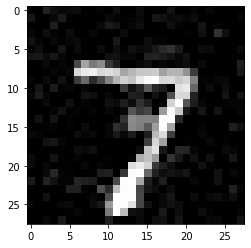

Iteration 110 distortion 2.2563 num_queries 22087
Iteration 120 distortion 2.1904 num_queries 23963
Iteration 130 distortion 2.1423 num_queries 25861
Iteration 140 distortion 2.0967 num_queries 27719
Iteration 150 distortion 2.0606 num_queries 29650
Iteration 160 distortion 2.0340 num_queries 31528
Iteration 170 distortion 2.0167 num_queries 33413
Iteration 180 distortion 2.0002 num_queries 35330
Iteration 190 distortion 1.9770 num_queries 37205
Iteration 200 distortion 1.9600 num_queries 39090


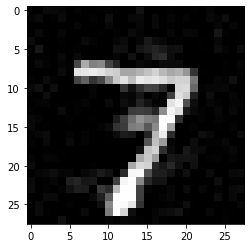

Iteration 210 distortion 1.9393 num_queries 41015
Iteration 220 distortion 1.9253 num_queries 42854
Iteration 230 distortion 1.9104 num_queries 44696
Iteration 240 distortion 1.9008 num_queries 46547
Iteration 250 distortion 1.8883 num_queries 48458
Iteration 260 distortion 1.8804 num_queries 50323
Iteration 270 distortion 1.8702 num_queries 52213
Iteration 280 distortion 1.8611 num_queries 54061
Iteration 290 distortion 1.8529 num_queries 55941
Iteration 300 distortion 1.8444 num_queries 57861


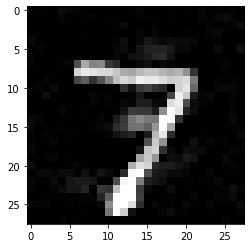

Iteration 310 distortion 1.8392 num_queries 59721
Iteration 320 distortion 1.8353 num_queries 61581
Iteration 330 distortion 1.8307 num_queries 63491
Iteration 340 distortion 1.8243 num_queries 65443
Iteration 350 distortion 1.8187 num_queries 67318
Iteration 360 distortion 1.8142 num_queries 69266
Iteration 370 distortion 1.8098 num_queries 71261
Iteration 380 distortion 1.8056 num_queries 73196
Iteration 390 distortion 1.8044 num_queries 76577

Adversarial Example Found Successfully: distortion 1.8044 target 3 queries 80172 
Time: 55.8117 seconds


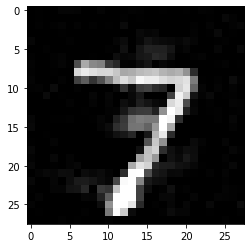

image batch: 1
Searching for the initial direction on 100 random directions: 
--------> Found distortion 20.2277
--------> Found distortion 19.2837
--------> Found distortion 18.1427
--------> Found distortion 15.4665
--------> Found distortion 14.8374
--------> Found distortion 14.3282
==========> Found best distortion 14.3282 in 0.2209 seconds using 301 queries
Iteration  10 distortion 8.0117 num_queries 2257
Iteration  20 distortion 6.3727 num_queries 4465
Iteration  30 distortion 5.4464 num_queries 6627
Iteration  40 distortion 5.0552 num_queries 8629
Iteration  50 distortion 4.6529 num_queries 10668
Iteration  60 distortion 4.3012 num_queries 12690
Iteration  70 distortion 4.0992 num_queries 14683
Iteration  80 distortion 3.9484 num_queries 16714
Iteration  90 distortion 3.8415 num_queries 18801
Iteration 100 distortion 3.7545 num_queries 20765


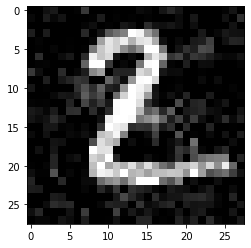

Iteration 110 distortion 3.5999 num_queries 22772
Iteration 120 distortion 3.5066 num_queries 24775
Iteration 130 distortion 3.4393 num_queries 26755
Iteration 140 distortion 3.3914 num_queries 28778
Iteration 150 distortion 3.3420 num_queries 30724
Iteration 160 distortion 3.2745 num_queries 32702
Iteration 170 distortion 3.2387 num_queries 34605
Iteration 180 distortion 3.1933 num_queries 36491
Iteration 190 distortion 3.1603 num_queries 38313
Iteration 200 distortion 3.1253 num_queries 40206


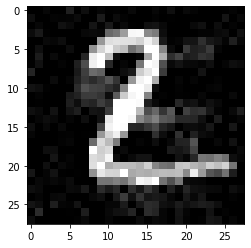

Iteration 210 distortion 3.0983 num_queries 42077
Iteration 220 distortion 3.0676 num_queries 43922
Iteration 230 distortion 3.0381 num_queries 45820
Iteration 240 distortion 3.0092 num_queries 47697
Iteration 250 distortion 2.9919 num_queries 52735

Adversarial Example Found Successfully: distortion 2.9919 target 8 queries 54557 
Time: 37.9156 seconds


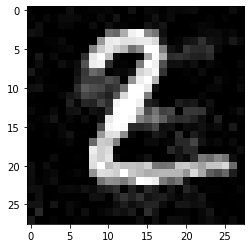

image batch: 2
Searching for the initial direction on 100 random directions: 
--------> Found distortion 11.0326
--------> Found distortion 9.4533
--------> Found distortion 8.1595
--------> Found distortion 7.3981
--------> Found distortion 7.1213
==========> Found best distortion 7.1213 in 0.2130 seconds using 298 queries
Iteration  10 distortion 4.1717 num_queries 2167
Iteration  20 distortion 3.1347 num_queries 4198
Iteration  30 distortion 2.7153 num_queries 6204
Iteration  40 distortion 2.4456 num_queries 8186
Iteration  50 distortion 2.2099 num_queries 10172
Iteration  60 distortion 2.0605 num_queries 12074
Iteration  70 distortion 1.9230 num_queries 13995
Iteration  80 distortion 1.8426 num_queries 15867
Iteration  90 distortion 1.7795 num_queries 17754
Iteration 100 distortion 1.7043 num_queries 19687


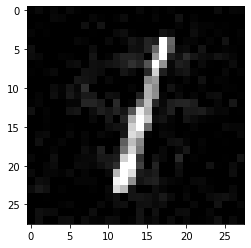

Iteration 110 distortion 1.6644 num_queries 21535
Iteration 120 distortion 1.6168 num_queries 23436
Iteration 130 distortion 1.5839 num_queries 25205
Iteration 140 distortion 1.5513 num_queries 26962
Iteration 150 distortion 1.5200 num_queries 28755
Iteration 160 distortion 1.5009 num_queries 30504
Iteration 170 distortion 1.4834 num_queries 32238
Iteration 180 distortion 1.4665 num_queries 33986
Iteration 190 distortion 1.4580 num_queries 35718
Iteration 200 distortion 1.4455 num_queries 37460


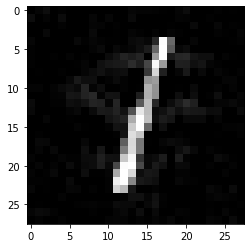

Iteration 210 distortion 1.4318 num_queries 39218
Iteration 220 distortion 1.4222 num_queries 40949
Iteration 230 distortion 1.4134 num_queries 42699
Iteration 240 distortion 1.4044 num_queries 44414
Iteration 250 distortion 1.3971 num_queries 46143
Iteration 260 distortion 1.3917 num_queries 47853
Iteration 270 distortion 1.3824 num_queries 49563
Iteration 280 distortion 1.3754 num_queries 51306
Iteration 290 distortion 1.3696 num_queries 53046
Iteration 300 distortion 1.3603 num_queries 54758


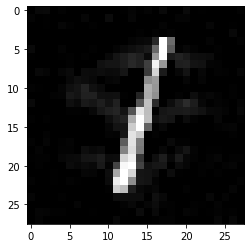

Iteration 310 distortion 1.3547 num_queries 56482
Iteration 320 distortion 1.3494 num_queries 58236
Iteration 330 distortion 1.3455 num_queries 59972
Iteration 340 distortion 1.3416 num_queries 61712
Iteration 350 distortion 1.3376 num_queries 63408
Iteration 360 distortion 1.3354 num_queries 66819

Adversarial Example Found Successfully: distortion 1.3354 target 8 queries 69675 
Time: 49.8736 seconds


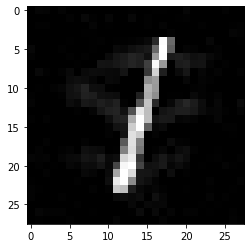

image batch: 3
Searching for the initial direction on 100 random directions: 
--------> Found distortion 23.6498
--------> Found distortion 20.7610
--------> Found distortion 20.7439
--------> Found distortion 17.3456
==========> Found best distortion 17.3456 in 0.1623 seconds using 221 queries
Iteration  10 distortion 9.3120 num_queries 2355
Iteration  20 distortion 7.1715 num_queries 4629
Iteration  30 distortion 5.4653 num_queries 6854
Iteration  40 distortion 4.8085 num_queries 8988
Iteration  50 distortion 4.4135 num_queries 11101
Iteration  60 distortion 4.0934 num_queries 13186
Iteration  70 distortion 3.8067 num_queries 15194
Iteration  80 distortion 3.6572 num_queries 17180
Iteration  90 distortion 3.4646 num_queries 19261
Iteration 100 distortion 3.3341 num_queries 21284


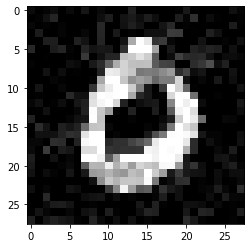

Iteration 110 distortion 3.2430 num_queries 23226
Iteration 120 distortion 3.1915 num_queries 25115
Iteration 130 distortion 3.1226 num_queries 26988
Iteration 140 distortion 3.0539 num_queries 28884
Iteration 150 distortion 2.9924 num_queries 30774
Iteration 160 distortion 2.9570 num_queries 32651
Iteration 170 distortion 2.9154 num_queries 34555
Iteration 180 distortion 2.8836 num_queries 36393
Iteration 190 distortion 2.8453 num_queries 38233
Iteration 200 distortion 2.8207 num_queries 40091


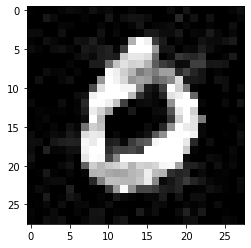

Iteration 210 distortion 2.8043 num_queries 41940
Iteration 220 distortion 2.7745 num_queries 43776
Iteration 230 distortion 2.7517 num_queries 45628
Iteration 240 distortion 2.7358 num_queries 47492
Iteration 250 distortion 2.7215 num_queries 49326
Iteration 260 distortion 2.7041 num_queries 51195
Iteration 270 distortion 2.6871 num_queries 53015
Iteration 280 distortion 2.6741 num_queries 54883
Iteration 290 distortion 2.6593 num_queries 56748
Iteration 300 distortion 2.6501 num_queries 58683


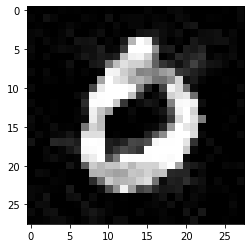

Iteration 310 distortion 2.6432 num_queries 60545
Iteration 320 distortion 2.6333 num_queries 62454
Iteration 330 distortion 2.6236 num_queries 64393
Iteration 340 distortion 2.6142 num_queries 66255
Iteration 350 distortion 2.6072 num_queries 68370

Adversarial Example Found Successfully: distortion 2.6061 target 4 queries 74435 
Time: 51.8625 seconds


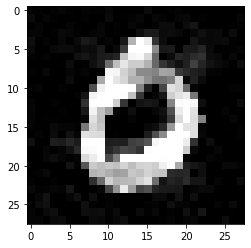

image batch: 4
Searching for the initial direction on 100 random directions: 
--------> Found distortion 22.1668
--------> Found distortion 18.3034
--------> Found distortion 16.1457
--------> Found distortion 15.0462
--------> Found distortion 14.0748
==========> Found best distortion 14.0748 in 0.1763 seconds using 256 queries
Iteration  10 distortion 5.4833 num_queries 2467
Iteration  20 distortion 3.7117 num_queries 4704
Iteration  30 distortion 3.0331 num_queries 6807
Iteration  40 distortion 2.6412 num_queries 8845
Iteration  50 distortion 2.3391 num_queries 10805
Iteration  60 distortion 2.1541 num_queries 12761
Iteration  70 distortion 2.0816 num_queries 14674
Iteration  80 distortion 1.9935 num_queries 16610
Iteration  90 distortion 1.9405 num_queries 18597
Iteration 100 distortion 1.8726 num_queries 20500


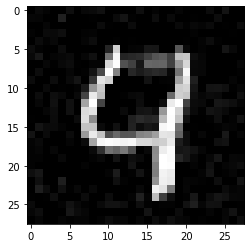

Iteration 110 distortion 1.8309 num_queries 22403
Iteration 120 distortion 1.7800 num_queries 24330
Iteration 130 distortion 1.7447 num_queries 26409
Iteration 140 distortion 1.7050 num_queries 28347
Iteration 150 distortion 1.6700 num_queries 30230
Iteration 160 distortion 1.6502 num_queries 32079
Iteration 170 distortion 1.6253 num_queries 33957
Iteration 180 distortion 1.6016 num_queries 35751
Iteration 190 distortion 1.5790 num_queries 37495
Iteration 200 distortion 1.5661 num_queries 39240


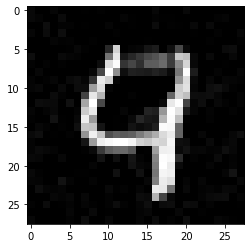

Iteration 210 distortion 1.5491 num_queries 41130
Iteration 220 distortion 1.5367 num_queries 42884
Iteration 230 distortion 1.5283 num_queries 44610
Iteration 240 distortion 1.5237 num_queries 46616

Adversarial Example Found Successfully: distortion 1.5229 target 9 queries 53594 
Time: 37.3649 seconds


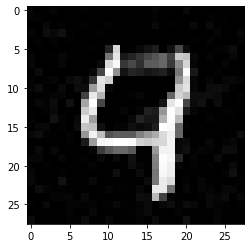

image batch: 5
Searching for the initial direction on 100 random directions: 
--------> Found distortion 14.2197
--------> Found distortion 12.1809
--------> Found distortion 11.1767
--------> Found distortion 10.2726
--------> Found distortion 10.2309
--------> Found distortion 9.9485
--------> Found distortion 9.5018
--------> Found distortion 9.0070
==========> Found best distortion 9.0070 in 0.2479 seconds using 357 queries
Iteration  10 distortion 5.4451 num_queries 2262
Iteration  20 distortion 3.9805 num_queries 4530
Iteration  30 distortion 3.3886 num_queries 6698
Iteration  40 distortion 3.0639 num_queries 8676
Iteration  50 distortion 2.8318 num_queries 10637
Iteration  60 distortion 2.6765 num_queries 12581
Iteration  70 distortion 2.5445 num_queries 14472
Iteration  80 distortion 2.4477 num_queries 16354
Iteration  90 distortion 2.3535 num_queries 18256
Iteration 100 distortion 2.2842 num_queries 20100


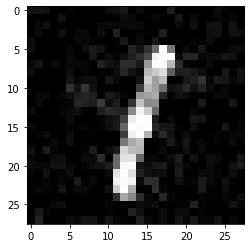

Iteration 110 distortion 2.2260 num_queries 22021
Iteration 120 distortion 2.1609 num_queries 23957
Iteration 130 distortion 2.1178 num_queries 25830
Iteration 140 distortion 2.0742 num_queries 27730
Iteration 150 distortion 2.0322 num_queries 29610
Iteration 160 distortion 1.9967 num_queries 31511
Iteration 170 distortion 1.9696 num_queries 33333
Iteration 180 distortion 1.9523 num_queries 35237
Iteration 190 distortion 1.9275 num_queries 37094
Iteration 200 distortion 1.9076 num_queries 38955


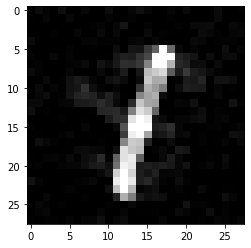

Iteration 210 distortion 1.8905 num_queries 40845
Iteration 220 distortion 1.8896 num_queries 44476

Adversarial Example Found Successfully: distortion 1.8887 target 8 queries 47789 
Time: 32.7883 seconds


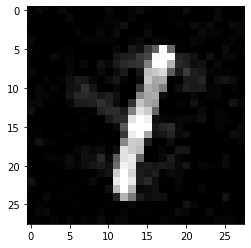

image batch: 6
Searching for the initial direction on 100 random directions: 
--------> Found distortion 10.9227
--------> Found distortion 10.0284
--------> Found distortion 9.1624
--------> Found distortion 8.3492
--------> Found distortion 8.3489
--------> Found distortion 7.9666
==========> Found best distortion 7.9666 in 0.2366 seconds using 314 queries
Iteration  10 distortion 3.1855 num_queries 2240
Iteration  20 distortion 2.5788 num_queries 4191
Iteration  30 distortion 2.1809 num_queries 6231
Iteration  40 distortion 1.9028 num_queries 8144
Iteration  50 distortion 1.6895 num_queries 10126
Iteration  60 distortion 1.5970 num_queries 11921
Iteration  70 distortion 1.5173 num_queries 13719
Iteration  80 distortion 1.4408 num_queries 15474
Iteration  90 distortion 1.3985 num_queries 17200
Iteration 100 distortion 1.3525 num_queries 19000


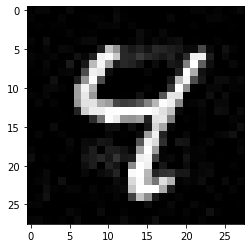

Iteration 110 distortion 1.3118 num_queries 20752
Iteration 120 distortion 1.2730 num_queries 22568
Iteration 130 distortion 1.2480 num_queries 24328
Iteration 140 distortion 1.2282 num_queries 26079
Iteration 150 distortion 1.2108 num_queries 27799
Iteration 160 distortion 1.1943 num_queries 29548
Iteration 170 distortion 1.1722 num_queries 31323
Iteration 180 distortion 1.1558 num_queries 33153
Iteration 190 distortion 1.1458 num_queries 34919
Iteration 200 distortion 1.1339 num_queries 36679


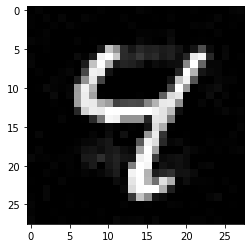

Iteration 210 distortion 1.1283 num_queries 38431
Iteration 220 distortion 1.1198 num_queries 40159
Iteration 230 distortion 1.1100 num_queries 41875
Iteration 240 distortion 1.1017 num_queries 43615
Iteration 250 distortion 1.0953 num_queries 45400
Iteration 260 distortion 1.0885 num_queries 47170
Iteration 270 distortion 1.0850 num_queries 48936
Iteration 280 distortion 1.0800 num_queries 50702
Iteration 290 distortion 1.0740 num_queries 52474
Iteration 300 distortion 1.0734 num_queries 54965


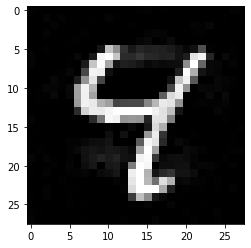


Adversarial Example Found Successfully: distortion 1.0734 target 8 queries 60454 
Time: 42.0288 seconds


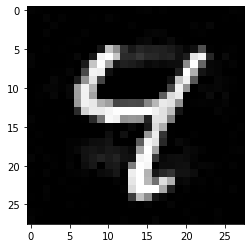

image batch: 7
Searching for the initial direction on 100 random directions: 
--------> Found distortion 11.0201
--------> Found distortion 9.6334
--------> Found distortion 9.3704
--------> Found distortion 8.1277
--------> Found distortion 8.0221
==========> Found best distortion 8.0221 in 0.2280 seconds using 298 queries
Iteration  10 distortion 3.8324 num_queries 2332
Iteration  20 distortion 2.7913 num_queries 4506
Iteration  30 distortion 2.5182 num_queries 6416
Iteration  40 distortion 2.1687 num_queries 8427
Iteration  50 distortion 1.9964 num_queries 10417
Iteration  60 distortion 1.9104 num_queries 12345
Iteration  70 distortion 1.7952 num_queries 14233
Iteration  80 distortion 1.7457 num_queries 16167
Iteration  90 distortion 1.6874 num_queries 18094
Iteration 100 distortion 1.6291 num_queries 19981


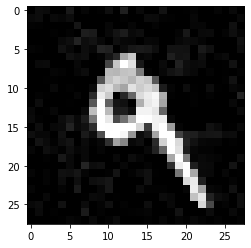

Iteration 110 distortion 1.5754 num_queries 21751
Iteration 120 distortion 1.5431 num_queries 23541
Iteration 130 distortion 1.5121 num_queries 25276
Iteration 140 distortion 1.4905 num_queries 27130
Iteration 150 distortion 1.4658 num_queries 29028
Iteration 160 distortion 1.4406 num_queries 30794
Iteration 170 distortion 1.4260 num_queries 32516
Iteration 180 distortion 1.4133 num_queries 34302
Iteration 190 distortion 1.4006 num_queries 36073
Iteration 200 distortion 1.3870 num_queries 37933


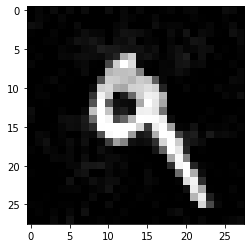


Adversarial Example Found Successfully: distortion 1.3870 target 4 queries 43843 
Time: 30.4667 seconds


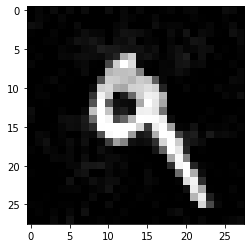

image batch: 8
Searching for the initial direction on 100 random directions: 
--------> Found distortion 21.9925
--------> Found distortion 13.8548
--------> Found distortion 13.7946
--------> Found distortion 11.9700
--------> Found distortion 11.9390
--------> Found distortion 10.5300
==========> Found best distortion 10.5300 in 0.2325 seconds using 319 queries
Iteration  10 distortion 4.6115 num_queries 2340
Iteration  20 distortion 3.2478 num_queries 4430
Iteration  30 distortion 2.7375 num_queries 6482
Iteration  40 distortion 2.3396 num_queries 8483
Iteration  50 distortion 2.1509 num_queries 10426
Iteration  60 distortion 1.9716 num_queries 12329
Iteration  70 distortion 1.8488 num_queries 14231
Iteration  80 distortion 1.7941 num_queries 16103
Iteration  90 distortion 1.7303 num_queries 17999
Iteration 100 distortion 1.6731 num_queries 19905


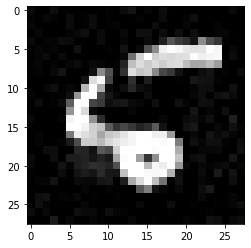

Iteration 110 distortion 1.6218 num_queries 21733
Iteration 120 distortion 1.5799 num_queries 23499
Iteration 130 distortion 1.5496 num_queries 25223
Iteration 140 distortion 1.5228 num_queries 26948
Iteration 150 distortion 1.4983 num_queries 28708
Iteration 160 distortion 1.4700 num_queries 30440
Iteration 170 distortion 1.4415 num_queries 32197
Iteration 180 distortion 1.4197 num_queries 33931
Iteration 190 distortion 1.4040 num_queries 35694
Iteration 200 distortion 1.3874 num_queries 37441


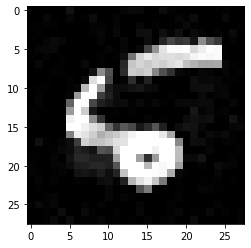

Iteration 210 distortion 1.3708 num_queries 39158
Iteration 220 distortion 1.3630 num_queries 40910
Iteration 230 distortion 1.3517 num_queries 42674
Iteration 240 distortion 1.3468 num_queries 44398
Iteration 250 distortion 1.3396 num_queries 46194
Iteration 260 distortion 1.3343 num_queries 47944
Iteration 270 distortion 1.3268 num_queries 49679
Iteration 280 distortion 1.3205 num_queries 51669
Iteration 290 distortion 1.3197 num_queries 56580

Adversarial Example Found Successfully: distortion 1.3197 target 6 queries 58765 
Time: 40.9462 seconds


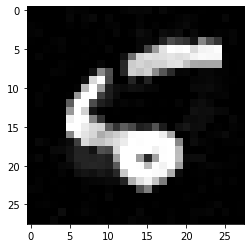

image batch: 9
Searching for the initial direction on 100 random directions: 
--------> Found distortion 10.2435
--------> Found distortion 9.5930
--------> Found distortion 8.3625
==========> Found best distortion 8.3625 in 0.1863 seconds using 259 queries
Iteration  10 distortion 4.7027 num_queries 2164
Iteration  20 distortion 3.4224 num_queries 4372
Iteration  30 distortion 2.9647 num_queries 6455
Iteration  40 distortion 2.6800 num_queries 8407
Iteration  50 distortion 2.4188 num_queries 10390
Iteration  60 distortion 2.3124 num_queries 12311
Iteration  70 distortion 2.2107 num_queries 14257
Iteration  80 distortion 2.1266 num_queries 16299
Iteration  90 distortion 2.0559 num_queries 18246
Iteration 100 distortion 1.9940 num_queries 20143


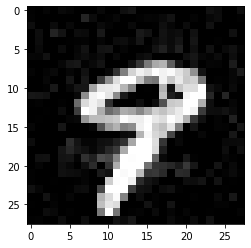

Iteration 110 distortion 1.8980 num_queries 22058
Iteration 120 distortion 1.8586 num_queries 23978
Iteration 130 distortion 1.8062 num_queries 25881
Iteration 140 distortion 1.7891 num_queries 29757

Adversarial Example Found Successfully: distortion 1.7884 target 8 queries 33800 
Time: 22.9623 seconds


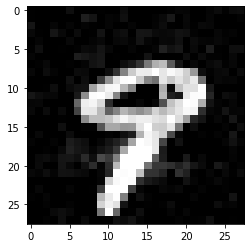

image batch: 10
saving logs to numpy array


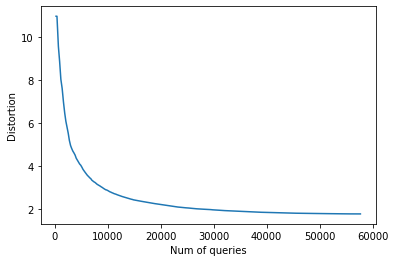

In [ ]:
amodel = PytorchModel(net, bounds=[0, 1], num_classes=10)
attack = OPT_attack(amodel)

total_r_count = 0
total_clean_count = 0
total_distance = 0

for i, (xi, yi) in enumerate(test_loader):
    print(f"image batch: {i}")
    if i == args.test_batch:
        break

    xi, yi = xi.cuda(), yi.cuda()
    adv = attack(xi, yi, epsilon=args.epsilon, TARGETED=args.targeted)

    # 결과 출력(MNIST의 경우 l_2 distortion이 2.0 아래로 내려가면 성공적)
    img = torchvision.transforms.ToPILImage()(torch.clamp(adv, min=0, max=1).squeeze(0))
    plt.imshow(img, cmap='gray') # for grayscale
    plt.show()

    if args.targeted == False:
        r_count = (torch.max(amodel.predict(adv), 1)[1] == yi).nonzero().shape[0]
        clean_count = (torch.max(amodel.predict(xi), 1)[1] == yi).nonzero().shape[0]
        total_r_count += r_count
        total_clean_count += clean_count
        total_distance += distance(adv, xi, norm=args.norm)

    if i == 0:
        logs = torch.zeros(attack.get_log().size())
    logs += attack.get_log()

logs /= args.test_batch
print("saving logs to numpy array")
npy_file = "log.npy"
np.save(npy_file,logs.numpy())

plot_log = np.load(npy_file)
plt.plot(plot_log[:,1], plot_log[:,0])
plt.ylabel('Distortion')
plt.xlabel('Num of queries')
plt.show()